XGBoost Regression - 'real-world' example: Californian Housing Dataset

https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

In [ ]:
!pip install pyGPGO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=070c9067f820dc61972b71ad17387e1fc5224485d61a8daad5dba4e3bb6543d4
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [ ]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import time

from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm
from joblib import Parallel, delayed
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pandas_datareader import data

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Read data in pandas dataframe:
df_train =  pd.read_csv('/content/sample_data/california_housing_train.csv')


In [ ]:
# List first rows:

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
# Remove missing data:

df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

New size: 17000


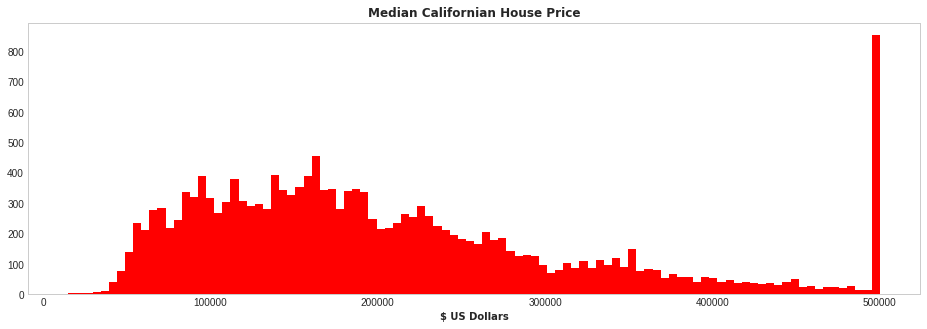

In [ ]:
# Histogram fare plot:

df_train.median_house_value.hist(bins=100, figsize=(16,5), color = "red")
plt.xlabel('$ US Dollars', weight = 'bold', family = 'Arial')
plt.title('Median Californian House Price', weight = 'bold', family = 'Arial')
plt.grid(b=None)

In [ ]:
y = df_train.median_house_value.values + 1e-10
y ### for supervised learning: output vector y

array([ 66900.,  80100.,  85700., ..., 103600.,  85800.,  94600.])

In [ ]:
# List first rows (post-cleaning):

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
X = df_train.drop(['median_house_value'], axis = 1)
X.head() ### for supervised learning: input matrix X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250


In [ ]:
### Optimum rmse: regression model objective function is Root Mean Square Error (RMSE); 
### Should be minimized (as close to zero as possible):

y_global_orig = 0

In [ ]:
### Bayesian Optimization - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points

util = 'EI'
n_init = 5 # random initialisations
opt = True

test_perc = 0.90
train_perc = 1 - test_perc

n_test = int(len(df_train) * test_perc)
n_train = int(len(df_train) - n_test)

eps = 1e-08

In [ ]:
### Objective function:

if obj_func == 'XGBoost': # 6-D
            
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    dim = 6
    
    max_iter = 30  # iterations of Bayesian optimization
    
    operator = 1 
    
    n_est = 5

In [ ]:
n_start_AcqFunc = max_iter


In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [ ]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
    

In [ ]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [ ]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_exact = str(inverse * self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_exact = BOLD + OKGREEN + max_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc_exact, max_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_approx = str(inverse * self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_approx = BOLD + OKGREEN + max_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc, max_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
start_approx = time.time()
start_approx

1660828071.5935922

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_1 = approx_1.getResult()[0]
params_approx_1['max_depth'] = int(params_approx_1['max_depth'])
params_approx_1['min_child_weight'] = int(params_approx_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train1 = xgb.DMatrix(X_train1, y_train1)
dX_approx_test1 = xgb.DMatrix(X_test1, y_test1)
model_approx_1 = xgb.train(params_approx_1, dX_approx_train1)
pred_approx_1 = model_approx_1.predict(dX_approx_test1)

rmse_approx_1 = np.sqrt(mean_squared_error(pred_approx_1, y_test1))
rmse_approx_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 0.848101320876155	 0.7386468688809501	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 0.7469689781479785	 0.7386468688809501	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 0.8079963708366673	 0.7386468688809501	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 0.7386468688809501	 0.7386468688809501	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 0.937768916815817	 0.7386468688809501	    	    
1  	 [ 7.86951474  0.6406733  11.          0.78919481 19.          0.44182296]	 0.8126185461054997	 0.7386468688809501	 0.8206578445592323	 0.8206578445592323
2  	 [ 0.74723898  0.36469704 11.          0.84902862 15.          0.10419698]	 0.93187040

61032.2252967339

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_2 = approx_2.getResult()[0]
params_approx_2['max_depth'] = int(params_approx_2['max_depth'])
params_approx_2['min_child_weight'] = int(params_approx_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train2 = xgb.DMatrix(X_train2, y_train2)
dX_approx_test2 = xgb.DMatrix(X_test2, y_test2)
model_approx_2 = xgb.train(params_approx_2, dX_approx_train2)
pred_approx_2 = model_approx_2.predict(dX_approx_test2)

rmse_approx_2 = np.sqrt(mean_squared_error(pred_approx_2, y_test2))
rmse_approx_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 0.9157817005982263	 0.8490988745111359	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 0.8517975125315337	 0.8490988745111359	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 0.8490988745111359	 0.8490988745111359	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 0.9839177202713774	 0.8490988745111359	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 0.9688138526063573	 0.8490988745111359	    	    
1	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]	 0.7933779577878181	 0.7933779577878181	 0.9363290000636096	 0.9363290000636096
2	 [ 2.17907321  8.34965852  5.          0.91660625 18.          0.97349298]	 0.7753470044

61531.263428159866

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_3 = approx_3.getResult()[0]
params_approx_3['max_depth'] = int(params_approx_3['max_depth'])
params_approx_3['min_child_weight'] = int(params_approx_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train3 = xgb.DMatrix(X_train3, y_train3)
dX_approx_test3 = xgb.DMatrix(X_test3, y_test3)
model_approx_3 = xgb.train(params_approx_3, dX_approx_train3)
pred_approx_3 = model_approx_3.predict(dX_approx_test3)

rmse_approx_3 = np.sqrt(mean_squared_error(pred_approx_3, y_test3))
rmse_approx_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 1.1001019572672721	 0.8205570570239384	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 1.0968690738660336	 0.8205570570239384	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 0.8205570570239384	 0.8205570570239384	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 1.0984076753833096	 0.8205570570239384	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 0.8540219347978375	 0.8205570570239384	    	    
1  	 [1.56262424 9.7795241  5.         0.91450054 5.         0.53102391]	 0.8296591774144556	 0.8205570570239384	 0.9371109764855802	 0.9371109764855802
2	 [ 2.46535469  7.06056184  5.          0.53518488 13.          0.98930148]	 0.81595469

60546.88719249485

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_4 = approx_4.getResult()[0]
params_approx_4['max_depth'] = int(params_approx_4['max_depth'])
params_approx_4['min_child_weight'] = int(params_approx_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train4 = xgb.DMatrix(X_train4, y_train4)
dX_approx_test4 = xgb.DMatrix(X_test4, y_test4)
model_approx_4 = xgb.train(params_approx_4, dX_approx_train4)
pred_approx_4 = model_approx_4.predict(dX_approx_test4)

rmse_approx_4 = np.sqrt(mean_squared_error(pred_approx_4, y_test4))
rmse_approx_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 0.7650622398140196	 0.7505823286451517	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 0.7710732234684645	 0.7505823286451517	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 1.127900018061083	 0.7505823286451517	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 0.7505823286451517	 0.7505823286451517	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 0.9579573664970923	 0.7505823286451517	    	    
1  	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]	 1.1269429525174437	 0.7505823286451517	 0.8487712006003875	 0.8487712006003875
2  	 [ 0.90674561  6.32290535 11.          0.94435129  1.          0.40346185]	 0.8738592

61055.818606721616

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_5 = approx_5.getResult()[0]
params_approx_5['max_depth'] = int(params_approx_5['max_depth'])
params_approx_5['min_child_weight'] = int(params_approx_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train5 = xgb.DMatrix(X_train5, y_train5)
dX_approx_test5 = xgb.DMatrix(X_test5, y_test5)
model_approx_5 = xgb.train(params_approx_5, dX_approx_train5)
pred_approx_5 = model_approx_5.predict(dX_approx_test5)

rmse_approx_5 = np.sqrt(mean_squared_error(pred_approx_5, y_test5))
rmse_approx_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 0.7978949387548113	 0.7689238087022429	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 0.7689238087022429	 0.7689238087022429	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 0.9009085979032214	 0.7689238087022429	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 0.9616956128686873	 0.7689238087022429	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 0.8968042534595716	 0.7689238087022429	    	    
1  	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]	 0.9141640599232991	 0.7689238087022429	 0.8556018628713383	 0.8556018628713383
2  	 [ 3.90043826  0.30059527 11.          0.95660877 13.          0.16396145]	 0.965730275323

59612.82267483437

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_6 = approx_6.getResult()[0]
params_approx_6['max_depth'] = int(params_approx_6['max_depth'])
params_approx_6['min_child_weight'] = int(params_approx_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train6 = xgb.DMatrix(X_train6, y_train6)
dX_approx_test6 = xgb.DMatrix(X_test6, y_test6)
model_approx_6 = xgb.train(params_approx_6, dX_approx_train6)
pred_approx_6 = model_approx_6.predict(dX_approx_test6)

rmse_approx_6 = np.sqrt(mean_squared_error(pred_approx_6, y_test6))
rmse_approx_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 0.8708842589582968	 0.8009237324889021	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 0.868843701878103	 0.8009237324889021	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 0.8009237324889021	 0.8009237324889021	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 0.8412285708806564	 0.8009237324889021	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 1.0874405633037085	 0.8009237324889021	    	    
1  	 [ 2.83859384  1.8954219   7.          0.66740302 13.          0.2701964 ]	 1.077285755760575	 0.8009237324889021	 0.8926954750160718	 0.8926954750160718
2  	 [ 8.38264396  7.97650716 14.          0.82584689  4.          0.25017455]	 1.1030510584286708	 0.

60612.276130930455

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_7 = approx_7.getResult()[0]
params_approx_7['max_depth'] = int(params_approx_7['max_depth'])
params_approx_7['min_child_weight'] = int(params_approx_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train7 = xgb.DMatrix(X_train7, y_train7)
dX_approx_test7 = xgb.DMatrix(X_test7, y_test7)
model_approx_7 = xgb.train(params_approx_7, dX_approx_train7)
pred_approx_7 = model_approx_7.predict(dX_approx_test7)

rmse_approx_7 = np.sqrt(mean_squared_error(pred_approx_7, y_test7))
rmse_approx_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 0.7260880637055529	 0.7260880637055529	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 0.7424588384015385	 0.7260880637055529	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 0.8412720456029797	 0.7260880637055529	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 0.7736412232573235	 0.7260880637055529	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 0.7650415360356615	 0.7260880637055529	    	    
1  	 [3.43305102 3.00339076 8.         0.71322679 4.         0.33322219]	 0.9222990750260575	 0.7260880637055529	 0.7976991363780701	 0.7976991363780701
2  	 [ 8.27276329  5.80705371  6.          0.6575149  16.          0.66596626]	 0.7908681556639724	 

61351.93418054509

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_8 = approx_8.getResult()[0]
params_approx_8['max_depth'] = int(params_approx_8['max_depth'])
params_approx_8['min_child_weight'] = int(params_approx_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train8 = xgb.DMatrix(X_train8, y_train8)
dX_approx_test8 = xgb.DMatrix(X_test8, y_test8)
model_approx_8 = xgb.train(params_approx_8, dX_approx_train8)
pred_approx_8 = model_approx_8.predict(dX_approx_test8)

rmse_approx_8 = np.sqrt(mean_squared_error(pred_approx_8, y_test8))
rmse_approx_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 0.802823873653181	 0.7393694249818598	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 0.7439561063387327	 0.7393694249818598	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 0.8573744170126428	 0.7393694249818598	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 0.7605799870908501	 0.7393694249818598	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 0.7393694249818598	 0.7393694249818598	    	    
1	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]	 0.7341650428609557	 0.7341650428609557	 0.8115921066236932	 0.8115921066236932
2  	 [ 4.42530022  8.86662399 12.          0.55390756 19.          0.26906902]	 0.887308704

60822.98185938519

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_9 = approx_9.getResult()[0]
params_approx_9['max_depth'] = int(params_approx_9['max_depth'])
params_approx_9['min_child_weight'] = int(params_approx_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train9 = xgb.DMatrix(X_train9, y_train9)
dX_approx_test9 = xgb.DMatrix(X_test9, y_test9)
model_approx_9 = xgb.train(params_approx_9, dX_approx_train9)
pred_approx_9 = model_approx_9.predict(dX_approx_test9)

rmse_approx_9 = np.sqrt(mean_squared_error(pred_approx_9, y_test9))
rmse_approx_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 1.1242573295906948	 0.7785306461595496	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 1.1029639839305116	 0.7785306461595496	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 0.7785306461595496	 0.7785306461595496	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 0.8502721808074817	 0.7785306461595496	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 0.8007936005920335	 0.7785306461595496	    	    
1  	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]	 1.1406566629866908	 0.7785306461595496	 0.8870005129102835	 0.8870005129102835
2  	 [9.23885705 0.0495141  9.         0.5847098  7.         0.79832927]	 0.868022166757

60590.73520973802

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_10 = approx_10.getResult()[0]
params_approx_10['max_depth'] = int(params_approx_10['max_depth'])
params_approx_10['min_child_weight'] = int(params_approx_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train10 = xgb.DMatrix(X_train10, y_train10)
dX_approx_test10 = xgb.DMatrix(X_test10, y_test10)
model_approx_10 = xgb.train(params_approx_10, dX_approx_train10)
pred_approx_10 = model_approx_10.predict(dX_approx_test10)

rmse_approx_10 = np.sqrt(mean_squared_error(pred_approx_10, y_test10))
rmse_approx_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 1.0639310256047103	 0.7797034870948047	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 0.79580179662759	 0.7797034870948047	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 0.7797034870948047	 0.7797034870948047	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 0.7990514117028104	 0.7797034870948047	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 1.0587036817796267	 0.7797034870948047	    	    
1	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]	 0.7741723447560037	 0.7741723447560037	 0.8783154104219717	 0.8783154104219717
2  	 [ 3.05837423  0.98670899 11.          0.63714741 18.          0.46809298]	 0.8572799307158145

59828.20971834756

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_11 = approx_11.getResult()[0]
params_approx_11['max_depth'] = int(params_approx_11['max_depth'])
params_approx_11['min_child_weight'] = int(params_approx_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train11 = xgb.DMatrix(X_train11, y_train11)
dX_approx_test11 = xgb.DMatrix(X_test11, y_test11)
model_approx_11 = xgb.train(params_approx_11, dX_approx_train11)
pred_approx_11 = model_approx_11.predict(dX_approx_test11)

rmse_approx_11 = np.sqrt(mean_squared_error(pred_approx_11, y_test11))
rmse_approx_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 0.8177825188141039	 0.7287337628426743	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 0.7419480115539112	 0.7287337628426743	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 0.7287337628426743	 0.7287337628426743	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 0.7335645848611818	 0.7287337628426743	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 0.7441537376931249	 0.7287337628426743	    	    
1  	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]	 0.7482694480200888	 0.7287337628426743	 0.795485809986575	 0.795485809986575
2	 [ 0.59719728  4.15307516 11.          0.66501717  3.          0.95537014]	 0.7070648622

60792.02085716255

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_12 = approx_12.getResult()[0]
params_approx_12['max_depth'] = int(params_approx_12['max_depth'])
params_approx_12['min_child_weight'] = int(params_approx_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train12 = xgb.DMatrix(X_train12, y_train12)
dX_approx_test12 = xgb.DMatrix(X_test12, y_test12)
model_approx_12 = xgb.train(params_approx_12, dX_approx_train12)
pred_approx_12 = model_approx_12.predict(dX_approx_test12)

rmse_approx_12 = np.sqrt(mean_squared_error(pred_approx_12, y_test12))
rmse_approx_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 0.992708970032886	 0.7896346786115067	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 0.9050380263035862	 0.7896346786115067	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 0.8362986807103934	 0.7896346786115067	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 0.7896346786115067	 0.7896346786115067	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 0.9186387829358221	 0.7896346786115067	    	    
1  	 [9.46555822 8.57190559 5.         0.50164398 5.         0.71992807]	 0.8115376813007883	 0.7896346786115067	 0.8814586819932864	 0.8814586819932864
2  	 [ 3.78385301  2.21923666 12.          0.57141407  8.          0.55842631]	 0.8600045769145

61176.67622203579

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_13 = approx_13.getResult()[0]
params_approx_13['max_depth'] = int(params_approx_13['max_depth'])
params_approx_13['min_child_weight'] = int(params_approx_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train13 = xgb.DMatrix(X_train13, y_train13)
dX_approx_test13 = xgb.DMatrix(X_test13, y_test13)
model_approx_13 = xgb.train(params_approx_13, dX_approx_train13)
pred_approx_13 = model_approx_13.predict(dX_approx_test13)

rmse_approx_13 = np.sqrt(mean_squared_error(pred_approx_13, y_test13))
rmse_approx_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 0.7315012035187541	 0.7315012035187541	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 1.1319770010327717	 0.7315012035187541	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 0.9318565354152348	 0.7315012035187541	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 0.7799608780638936	 0.7315012035187541	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 1.1305934464937346	 0.7315012035187541	    	    
1  	 [1.51786663 9.25994479 9.         0.99792981 2.         0.61199673]	 0.7922048089873084	 0.7315012035187541	 0.8536976562883747	 0.8536976562883747
2  	 [6.93463528 1.25795731 8.         0.92695971 3.         0.9534311 ]	 0.736400936435

62109.01335398378

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_14 = approx_14.getResult()[0]
params_approx_14['max_depth'] = int(params_approx_14['max_depth'])
params_approx_14['min_child_weight'] = int(params_approx_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train14 = xgb.DMatrix(X_train14, y_train14)
dX_approx_test14 = xgb.DMatrix(X_test14, y_test14)
model_approx_14 = xgb.train(params_approx_14, dX_approx_train14)
pred_approx_14 = model_approx_14.predict(dX_approx_test14)

rmse_approx_14 = np.sqrt(mean_squared_error(pred_approx_14, y_test14))
rmse_approx_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 0.886516450243748	 0.7696523735238344	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 0.8159404842786963	 0.7696523735238344	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 0.9077084280320982	 0.7696523735238344	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 0.7696523735238344	 0.7696523735238344	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 0.9767143382937844	 0.7696523735238344	    	    
1  	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]	 0.9945462140035275	 0.7696523735238344	 0.8606700147454752	 0.8606700147454752
2  	 [ 9.16780803  5.31613214 10.          0.57182868  6.          0.98158575]	 0.7780694

60476.92208349806

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_15 = approx_15.getResult()[0]
params_approx_15['max_depth'] = int(params_approx_15['max_depth'])
params_approx_15['min_child_weight'] = int(params_approx_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train15 = xgb.DMatrix(X_train15, y_train15)
dX_approx_test15 = xgb.DMatrix(X_test15, y_test15)
model_approx_15 = xgb.train(params_approx_15, dX_approx_train15)
pred_approx_15 = model_approx_15.predict(dX_approx_test15)

rmse_approx_15 = np.sqrt(mean_squared_error(pred_approx_15, y_test15))
rmse_approx_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 0.7846478010899064	 0.7846478010899064	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 1.0448868808294456	 0.7846478010899064	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 1.0327067294213346	 0.7846478010899064	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 0.8536879526704689	 0.7846478010899064	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 1.0323325469581077	 0.7846478010899064	    	    
1  	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]	 0.810550884613735	 0.7846478010899064	 0.8953833870448279	 0.8953833870448279
2  	 [2.60517447 0.82584036 7.         0.6107555  4.         0.25427784]	 0.9535088265263

61931.472044342285

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_16 = approx_16.getResult()[0]
params_approx_16['max_depth'] = int(params_approx_16['max_depth'])
params_approx_16['min_child_weight'] = int(params_approx_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train16 = xgb.DMatrix(X_train16, y_train16)
dX_approx_test16 = xgb.DMatrix(X_test16, y_test16)
model_approx_16 = xgb.train(params_approx_16, dX_approx_train16)
pred_approx_16 = model_approx_16.predict(dX_approx_test16)

rmse_approx_16 = np.sqrt(mean_squared_error(pred_approx_16, y_test16))
rmse_approx_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 1.0442882316794924	 0.9988899440522335	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 1.034592364984854	 0.9988899440522335	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 0.9988899440522335	 0.9988899440522335	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 1.0616382201607613	 0.9988899440522335	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 1.0586655163441985	 0.9988899440522335	    	    
1	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]	 0.7588724777099193	 0.7588724777099193	 1.092210884518706	 1.092210884518706
2  	 [ 9.65014948  7.07834667 14.          0.88748515  2.          0.43513691]	 1.0357720753154218	

60365.903404577824

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_17 = approx_17.getResult()[0]
params_approx_17['max_depth'] = int(params_approx_17['max_depth'])
params_approx_17['min_child_weight'] = int(params_approx_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train17 = xgb.DMatrix(X_train17, y_train17)
dX_approx_test17 = xgb.DMatrix(X_test17, y_test17)
model_approx_17 = xgb.train(params_approx_17, dX_approx_train17)
pred_approx_17 = model_approx_17.predict(dX_approx_test17)

rmse_approx_17 = np.sqrt(mean_squared_error(pred_approx_17, y_test17))
rmse_approx_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 0.8160193762021096	 0.8160193762021096	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 0.9345750435828236	 0.8160193762021096	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 0.8609997448649105	 0.8160193762021096	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 0.9816665199899536	 0.8160193762021096	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 0.9568167510294832	 0.8160193762021096	    	    
1  	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]	 0.9860041719301801	 0.8160193762021096	 0.9065628526016722	 0.9065628526016722
2  	 [8.79462978 7.51560605 6.         0.76312232 8.         0.57156636]	 0.841883840187

62050.671085656184

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_18 = approx_18.getResult()[0]
params_approx_18['max_depth'] = int(params_approx_18['max_depth'])
params_approx_18['min_child_weight'] = int(params_approx_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train18 = xgb.DMatrix(X_train18, y_train18)
dX_approx_test18 = xgb.DMatrix(X_test18, y_test18)
model_approx_18 = xgb.train(params_approx_18, dX_approx_train18)
pred_approx_18 = model_approx_18.predict(dX_approx_test18)

rmse_approx_18 = np.sqrt(mean_squared_error(pred_approx_18, y_test18))
rmse_approx_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 0.9945504564494708	 0.8040972705253946	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 0.8040972705253946	 0.8040972705253946	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 0.9800705737387579	 0.8040972705253946	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 0.8208145553024886	 0.8040972705253946	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 0.8099770295888573	 0.8040972705253946	    	    
1  	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]	 0.8290526771960891	 0.8040972705253946	 0.8913052762090482	 0.8913052762090482
2	 [ 7.2764983   0.11744451 14.          0.65239666 17.          0.99049521]	 0.7717526578038573	 0.

62420.46131718859

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_19 = approx_19.getResult()[0]
params_approx_19['max_depth'] = int(params_approx_19['max_depth'])
params_approx_19['min_child_weight'] = int(params_approx_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train19 = xgb.DMatrix(X_train19, y_train19)
dX_approx_test19 = xgb.DMatrix(X_test19, y_test19)
model_approx_19 = xgb.train(params_approx_19, dX_approx_train19)
pred_approx_19 = model_approx_19.predict(dX_approx_test19)

rmse_approx_19 = np.sqrt(mean_squared_error(pred_approx_19, y_test19))
rmse_approx_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 0.9238143360620997	 0.824729580989813	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 0.9119597092034326	 0.824729580989813	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 1.1280473533716002	 0.824729580989813	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 0.885331313733569	 0.824729580989813	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 0.824729580989813	 0.824729580989813	    	    
1	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]	 0.79346025102973	 0.79346025102973	 0.9221585299132189	 0.9221585299132189
2  	 [ 9.87536409  7.17591217 14.          0.99713522 17.          0.55460731]	 0.8875735409405836	 0

60977.67575935616

In [ ]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_20 = approx_20.getResult()[0]
params_approx_20['max_depth'] = int(params_approx_20['max_depth'])
params_approx_20['min_child_weight'] = int(params_approx_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train20 = xgb.DMatrix(X_train20, y_train20)
dX_approx_test20 = xgb.DMatrix(X_test20, y_test20)
model_approx_20 = xgb.train(params_approx_20, dX_approx_train20)
pred_approx_20 = model_approx_20.predict(dX_approx_test20)

rmse_approx_20 = np.sqrt(mean_squared_error(pred_approx_20, y_test20))
rmse_approx_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 0.7520109919120059	 0.7520109919120059	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 0.7843437690505969	 0.7520109919120059	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 1.0380897569172567	 0.7520109919120059	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 0.9185289289653313	 0.7520109919120059	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 0.9180724641961298	 0.7520109919120059	    	    
1  	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]	 0.9254670555638643	 0.7520109919120059	 0.8502867513418078	 0.8502867513418078
2  	 [ 1.72798052  9.03285612 13.          0.50351094 19.          0.11416888]	 1.031463

60306.50974237256

In [ ]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1660830063.9417055

In [ ]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_1 = exact_1.getResult()[0]
params_exact_1['max_depth'] = int(params_exact_1['max_depth'])
params_exact_1['min_child_weight'] = int(params_exact_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train1 = xgb.DMatrix(X_train1, y_train1)
dX_exact_test1 = xgb.DMatrix(X_test1, y_test1)
model_exact_1 = xgb.train(params_exact_1, dX_exact_train1)
pred_exact_1 = model_exact_1.predict(dX_exact_test1)

rmse_exact_1 = np.sqrt(mean_squared_error(pred_exact_1, y_test1))
rmse_exact_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 0.848101320876155	 0.7386468688809501	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 0.7469689781479785	 0.7386468688809501	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 0.8079963708366673	 0.7386468688809501	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 0.7386468688809501	 0.7386468688809501	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 0.937768916815817	 0.7386468688809501	    	    
1  	 [ 7.86951474  0.6406733  11.          0.78919481 19.          0.44182296]	 0.8126185461054997	 0.7386468688809501	 0.8206578445592323	 0.8206578445592323
2  	 [ 0.74723898  0.36469704 11.          0.84902862 15.          0.10419698]	 0.93187040

59924.785613590866

In [43]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_2 = exact_2.getResult()[0]
params_exact_2['max_depth'] = int(params_exact_2['max_depth'])
params_exact_2['min_child_weight'] = int(params_exact_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train2 = xgb.DMatrix(X_train2, y_train2)
dX_exact_test2 = xgb.DMatrix(X_test2, y_test2)
model_exact_2 = xgb.train(params_exact_2, dX_exact_train2)
pred_exact_2 = model_exact_2.predict(dX_exact_test2)

rmse_exact_2 = np.sqrt(mean_squared_error(pred_exact_2, y_test2))
rmse_exact_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 0.9157817005982263	 0.8490988745111359	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 0.8517975125315337	 0.8490988745111359	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 0.8490988745111359	 0.8490988745111359	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 0.9839177202713774	 0.8490988745111359	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 0.9688138526063573	 0.8490988745111359	    	    
1	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]	 0.7933779577878181	 0.7933779577878181	 0.9363290000636096	 0.9363290000636096
2	 [ 2.17907321  8.34965852  5.          0.91660625 18.          0.97349298]	 0.7753470044

61286.16435498987

In [44]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_3 = exact_3.getResult()[0]
params_exact_3['max_depth'] = int(params_exact_3['max_depth'])
params_exact_3['min_child_weight'] = int(params_exact_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train3 = xgb.DMatrix(X_train3, y_train3)
dX_exact_test3 = xgb.DMatrix(X_test3, y_test3)
model_exact_3 = xgb.train(params_exact_3, dX_exact_train3)
pred_exact_3 = model_exact_3.predict(dX_exact_test3)

rmse_exact_3 = np.sqrt(mean_squared_error(pred_exact_3, y_test3))
rmse_exact_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 1.1001019572672721	 0.8205570570239384	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 1.0968690738660336	 0.8205570570239384	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 0.8205570570239384	 0.8205570570239384	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 1.0984076753833096	 0.8205570570239384	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 0.8540219347978375	 0.8205570570239384	    	    
1  	 [1.56262424 9.7795241  5.         0.91450054 5.         0.53102391]	 0.8296591774144556	 0.8205570570239384	 0.9371109764855802	 0.9371109764855802
2	 [ 2.46535469  7.06056184  5.          0.53518488 13.          0.98930148]	 0.81595469

59509.134777929154

In [50]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_4 = exact_4.getResult()[0]
params_exact_4['max_depth'] = int(params_exact_4['max_depth'])
params_exact_4['min_child_weight'] = int(params_exact_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train4 = xgb.DMatrix(X_train4, y_train4)
dX_exact_test4 = xgb.DMatrix(X_test4, y_test4)
model_exact_4 = xgb.train(params_exact_4, dX_exact_train4)
pred_exact_4 = model_exact_4.predict(dX_exact_test4)

rmse_exact_4 = np.sqrt(mean_squared_error(pred_exact_4, y_test4))
rmse_exact_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 0.7650622398140196	 0.7505823286451517	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 0.7710732234684645	 0.7505823286451517	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 1.127900018061083	 0.7505823286451517	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 0.7505823286451517	 0.7505823286451517	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 0.9579573664970923	 0.7505823286451517	    	    
1  	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]	 1.1269429525174437	 0.7505823286451517	 0.8487712006003875	 0.8487712006003875
2  	 [ 0.90674561  6.32290535 11.          0.94435129  1.          0.40346185]	 0.8738592

60881.67649252119

In [46]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_5 = exact_5.getResult()[0]
params_exact_5['max_depth'] = int(params_exact_5['max_depth'])
params_exact_5['min_child_weight'] = int(params_exact_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train5 = xgb.DMatrix(X_train5, y_train5)
dX_exact_test5 = xgb.DMatrix(X_test5, y_test5)
model_exact_5 = xgb.train(params_exact_5, dX_exact_train5)
pred_exact_5 = model_exact_5.predict(dX_exact_test5)

rmse_exact_5 = np.sqrt(mean_squared_error(pred_exact_5, y_test5))
rmse_exact_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 0.7978949387548113	 0.7689238087022429	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 0.7689238087022429	 0.7689238087022429	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 0.9009085979032214	 0.7689238087022429	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 0.9616956128686873	 0.7689238087022429	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 0.8968042534595716	 0.7689238087022429	    	    
1  	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]	 0.9141640599232991	 0.7689238087022429	 0.8556018628713383	 0.8556018628713383
2  	 [ 3.90043826  0.30059527 11.          0.95660877 13.          0.16396145]	 0.965730275323

60072.58580829538

In [48]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror', eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_6 = exact_6.getResult()[0]
params_exact_6['max_depth'] = int(params_exact_6['max_depth'])
params_exact_6['min_child_weight'] = int(params_exact_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train6 = xgb.DMatrix(X_train6, y_train6)
dX_exact_test6 = xgb.DMatrix(X_test6, y_test6)
model_exact_6 = xgb.train(params_exact_6, dX_exact_train6)
pred_exact_6 = model_exact_6.predict(dX_exact_test6)

rmse_exact_6 = np.sqrt(mean_squared_error(pred_exact_6, y_test6))
rmse_exact_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 0.8708842589582968	 0.8009237324889021	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 0.868843701878103	 0.8009237324889021	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 0.8009237324889021	 0.8009237324889021	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 0.8412285708806564	 0.8009237324889021	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 1.0874405633037085	 0.8009237324889021	    	    
1  	 [ 2.83859384  1.8954219   7.          0.66740302 13.          0.2701964 ]	 1.077285755760575	 0.8009237324889021	 0.8926954750160718	 0.8926954750160718
2  	 [ 8.38264396  7.97650716 14.          0.82584689  4.          0.25017455]	 1.1030510584286708	 0.

59357.988650322826

In [51]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_7 = exact_7.getResult()[0]
params_exact_7['max_depth'] = int(params_exact_7['max_depth'])
params_exact_7['min_child_weight'] = int(params_exact_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train7 = xgb.DMatrix(X_train7, y_train7)
dX_exact_test7 = xgb.DMatrix(X_test7, y_test7)
model_exact_7 = xgb.train(params_exact_7, dX_exact_train7)
pred_exact_7 = model_exact_7.predict(dX_exact_test7)

rmse_exact_7 = np.sqrt(mean_squared_error(pred_exact_7, y_test7))
rmse_exact_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 0.7260880637055529	 0.7260880637055529	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 0.7424588384015385	 0.7260880637055529	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 0.8412720456029797	 0.7260880637055529	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 0.7736412232573235	 0.7260880637055529	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 0.7650415360356615	 0.7260880637055529	    	    
1  	 [3.43305102 3.00339076 8.         0.71322679 4.         0.33322219]	 0.9222990750260575	 0.7260880637055529	 0.7976991363780701	 0.7976991363780701
2  	 [ 8.27276329  5.80705371  6.          0.6575149  16.          0.66596626]	 0.7908681556639724	 

59954.44736483102

In [52]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_8 = exact_8.getResult()[0]
params_exact_8['max_depth'] = int(params_exact_8['max_depth'])
params_exact_8['min_child_weight'] = int(params_exact_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train8 = xgb.DMatrix(X_train8, y_train8)
dX_exact_test8 = xgb.DMatrix(X_test8, y_test8)
model_exact_8 = xgb.train(params_exact_8, dX_exact_train8)
pred_exact_8 = model_exact_8.predict(dX_exact_test8)

rmse_exact_8 = np.sqrt(mean_squared_error(pred_exact_8, y_test8))
rmse_exact_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 0.802823873653181	 0.7393694249818598	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 0.7439561063387327	 0.7393694249818598	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 0.8573744170126428	 0.7393694249818598	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 0.7605799870908501	 0.7393694249818598	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 0.7393694249818598	 0.7393694249818598	    	    
1	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]	 0.7341650428609557	 0.7341650428609557	 0.8115921066236932	 0.8115921066236932
2  	 [ 4.42530022  8.86662399 12.          0.55390756 19.          0.26906902]	 0.887308704

59493.46322622606

In [53]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_9 = exact_9.getResult()[0]
params_exact_9['max_depth'] = int(params_exact_9['max_depth'])
params_exact_9['min_child_weight'] = int(params_exact_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train9 = xgb.DMatrix(X_train9, y_train9)
dX_exact_test9 = xgb.DMatrix(X_test9, y_test9)
model_exact_9 = xgb.train(params_exact_9, dX_exact_train9)
pred_exact_9 = model_exact_9.predict(dX_exact_test9)

rmse_exact_9 = np.sqrt(mean_squared_error(pred_exact_9, y_test9))
rmse_exact_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 1.1242573295906948	 0.7785306461595496	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 1.1029639839305116	 0.7785306461595496	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 0.7785306461595496	 0.7785306461595496	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 0.8502721808074817	 0.7785306461595496	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 0.8007936005920335	 0.7785306461595496	    	    
1  	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]	 1.1406566629866908	 0.7785306461595496	 0.8870005129102835	 0.8870005129102835
2  	 [9.23885705 0.0495141  9.         0.5847098  7.         0.79832927]	 0.868022166757

58909.59940760899

In [54]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_10 = exact_10.getResult()[0]
params_exact_10['max_depth'] = int(params_exact_10['max_depth'])
params_exact_10['min_child_weight'] = int(params_exact_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train10 = xgb.DMatrix(X_train10, y_train10)
dX_exact_test10 = xgb.DMatrix(X_test10, y_test10)
model_exact_10 = xgb.train(params_exact_10, dX_exact_train10)
pred_exact_10 = model_exact_10.predict(dX_exact_test10)

rmse_exact_10 = np.sqrt(mean_squared_error(pred_exact_10, y_test10))
rmse_exact_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 1.0639310256047103	 0.7797034870948047	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 0.79580179662759	 0.7797034870948047	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 0.7797034870948047	 0.7797034870948047	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 0.7990514117028104	 0.7797034870948047	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 1.0587036817796267	 0.7797034870948047	    	    
1	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]	 0.7741723447560037	 0.7741723447560037	 0.8783154104219717	 0.8783154104219717
2  	 [ 3.05837423  0.98670899 11.          0.63714741 18.          0.46809298]	 0.8572799307158145

60178.06288885992

In [55]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_11 = exact_11.getResult()[0]
params_exact_11['max_depth'] = int(params_exact_11['max_depth'])
params_exact_11['min_child_weight'] = int(params_exact_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train11 = xgb.DMatrix(X_train11, y_train11)
dX_exact_test11 = xgb.DMatrix(X_test11, y_test11)
model_exact_11 = xgb.train(params_exact_11, dX_exact_train11)
pred_exact_11 = model_exact_11.predict(dX_exact_test11)

rmse_exact_11 = np.sqrt(mean_squared_error(pred_exact_11, y_test11))
rmse_exact_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 0.8177825188141039	 0.7287337628426743	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 0.7419480115539112	 0.7287337628426743	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 0.7287337628426743	 0.7287337628426743	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 0.7335645848611818	 0.7287337628426743	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 0.7441537376931249	 0.7287337628426743	    	    
1  	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]	 0.7482694480200888	 0.7287337628426743	 0.795485809986575	 0.795485809986575
2	 [ 0.59719728  4.15307516 11.          0.66501717  3.          0.95537014]	 0.7070648622

61502.36723534204

In [56]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_12 = exact_12.getResult()[0]
params_exact_12['max_depth'] = int(params_exact_12['max_depth'])
params_exact_12['min_child_weight'] = int(params_exact_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train12 = xgb.DMatrix(X_train12, y_train12)
dX_exact_test12 = xgb.DMatrix(X_test12, y_test12)
model_exact_12 = xgb.train(params_exact_12, dX_exact_train12)
pred_exact_12 = model_exact_12.predict(dX_exact_test12)

rmse_exact_12 = np.sqrt(mean_squared_error(pred_exact_12, y_test12))
rmse_exact_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 0.992708970032886	 0.7896346786115067	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 0.9050380263035862	 0.7896346786115067	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 0.8362986807103934	 0.7896346786115067	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 0.7896346786115067	 0.7896346786115067	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 0.9186387829358221	 0.7896346786115067	    	    
1  	 [9.46555822 8.57190559 5.         0.50164398 5.         0.71992807]	 0.8115376813007883	 0.7896346786115067	 0.8814586819932864	 0.8814586819932864
2  	 [ 3.78385301  2.21923666 12.          0.57141407  8.          0.55842631]	 0.8600045769145

61494.6504599855

In [57]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_13 = exact_13.getResult()[0]
params_exact_13['max_depth'] = int(params_exact_13['max_depth'])
params_exact_13['min_child_weight'] = int(params_exact_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train13 = xgb.DMatrix(X_train13, y_train13)
dX_exact_test13 = xgb.DMatrix(X_test13, y_test13)
model_exact_13 = xgb.train(params_exact_13, dX_exact_train13)
pred_exact_13 = model_exact_13.predict(dX_exact_test13)

rmse_exact_13 = np.sqrt(mean_squared_error(pred_exact_13, y_test13))
rmse_exact_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 0.7315012035187541	 0.7315012035187541	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 1.1319770010327717	 0.7315012035187541	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 0.9318565354152348	 0.7315012035187541	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 0.7799608780638936	 0.7315012035187541	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 1.1305934464937346	 0.7315012035187541	    	    
1  	 [1.51786663 9.25994479 9.         0.99792981 2.         0.61199673]	 0.7922048089873084	 0.7315012035187541	 0.8536976562883747	 0.8536976562883747
2	 [10.         7.9358597 15.         1.        20.         1.       ]	 0.72847794454642

60138.510007365374

In [58]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_14 = exact_14.getResult()[0]
params_exact_14['max_depth'] = int(params_exact_14['max_depth'])
params_exact_14['min_child_weight'] = int(params_exact_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train14 = xgb.DMatrix(X_train14, y_train14)
dX_exact_test14 = xgb.DMatrix(X_test14, y_test14)
model_exact_14 = xgb.train(params_exact_14, dX_exact_train14)
pred_exact_14 = model_exact_14.predict(dX_exact_test14)

rmse_exact_14 = np.sqrt(mean_squared_error(pred_exact_14, y_test14))
rmse_exact_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 0.886516450243748	 0.7696523735238344	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 0.8159404842786963	 0.7696523735238344	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 0.9077084280320982	 0.7696523735238344	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 0.7696523735238344	 0.7696523735238344	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 0.9767143382937844	 0.7696523735238344	    	    
1  	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]	 0.9945462140035275	 0.7696523735238344	 0.8606700147454752	 0.8606700147454752
2	 [10. 10. 15.  1. 20.  1.]	 0.754288614897578	 0.754288614897578	 0.8664557060101586	 0

60569.20712257925

In [59]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_15 = exact_15.getResult()[0]
params_exact_15['max_depth'] = int(params_exact_15['max_depth'])
params_exact_15['min_child_weight'] = int(params_exact_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train15 = xgb.DMatrix(X_train15, y_train15)
dX_exact_test15 = xgb.DMatrix(X_test15, y_test15)
model_exact_15 = xgb.train(params_exact_15, dX_exact_train15)
pred_exact_15 = model_exact_15.predict(dX_exact_test15)

rmse_exact_15 = np.sqrt(mean_squared_error(pred_exact_15, y_test15))
rmse_exact_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 0.7846478010899064	 0.7846478010899064	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 1.0448868808294456	 0.7846478010899064	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 1.0327067294213346	 0.7846478010899064	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 0.8536879526704689	 0.7846478010899064	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 1.0323325469581077	 0.7846478010899064	    	    
1  	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]	 0.810550884613735	 0.7846478010899064	 0.8953833870448279	 0.8953833870448279
2  	 [2.60517447 0.82584036 7.         0.6107555  4.         0.25427784]	 0.9535088265263

61931.472044342285

In [60]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_16 = exact_16.getResult()[0]
params_exact_16['max_depth'] = int(params_exact_16['max_depth'])
params_exact_16['min_child_weight'] = int(params_exact_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train16 = xgb.DMatrix(X_train16, y_train16)
dX_exact_test16 = xgb.DMatrix(X_test16, y_test16)
model_exact_16 = xgb.train(params_exact_16, dX_exact_train16)
pred_exact_16 = model_exact_16.predict(dX_exact_test16)

rmse_exact_16 = np.sqrt(mean_squared_error(pred_exact_16, y_test16))
rmse_exact_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 1.0442882316794924	 0.9988899440522335	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 1.034592364984854	 0.9988899440522335	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 0.9988899440522335	 0.9988899440522335	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 1.0616382201607613	 0.9988899440522335	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 1.0586655163441985	 0.9988899440522335	    	    
1	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]	 0.7588724777099193	 0.7588724777099193	 1.092210884518706	 1.092210884518706
2  	 [ 9.65014948  7.07834667 14.          0.88748515  2.          0.43513691]	 1.0357720753154218	

60107.77727132956

In [61]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_17 = exact_17.getResult()[0]
params_exact_17['max_depth'] = int(params_exact_17['max_depth'])
params_exact_17['min_child_weight'] = int(params_exact_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train17 = xgb.DMatrix(X_train17, y_train17)
dX_exact_test17 = xgb.DMatrix(X_test17, y_test17)
model_exact_17 = xgb.train(params_exact_17, dX_exact_train17)
pred_exact_17 = model_exact_17.predict(dX_exact_test17)

rmse_exact_17 = np.sqrt(mean_squared_error(pred_exact_17, y_test17))
rmse_exact_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 0.8160193762021096	 0.8160193762021096	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 0.9345750435828236	 0.8160193762021096	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 0.8609997448649105	 0.8160193762021096	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 0.9816665199899536	 0.8160193762021096	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 0.9568167510294832	 0.8160193762021096	    	    
1  	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]	 0.9860041719301801	 0.8160193762021096	 0.9065628526016722	 0.9065628526016722
2  	 [8.79462978 7.51560605 6.         0.76312232 8.         0.57156636]	 0.841883840187

59823.1409719917

In [62]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_18 = exact_18.getResult()[0]
params_exact_18['max_depth'] = int(params_exact_18['max_depth'])
params_exact_18['min_child_weight'] = int(params_exact_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train18 = xgb.DMatrix(X_train18, y_train18)
dX_exact_test18 = xgb.DMatrix(X_test18, y_test18)
model_exact_18 = xgb.train(params_exact_18, dX_exact_train18)
pred_exact_18 = model_exact_18.predict(dX_exact_test18)

rmse_exact_18 = np.sqrt(mean_squared_error(pred_exact_18, y_test18))
rmse_exact_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 0.9747807501509798	 0.8413213471093884	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 0.8434056917425027	 0.8413213471093884	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 0.9720565145525129	 0.8413213471093884	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 0.8568115101817837	 0.8413213471093884	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 0.8413213471093884	 0.8413213471093884	    	    
1  	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]	 0.8631585877624761	 0.8413213471093884	 0.9254718437863916	 0.9254718437863916
2	 [ 7.2764983   0.11744451 14.          0.65239666 17.          0.99049521]	 0.7571977630434763	 0.

60789.308390329395

In [63]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_19 = exact_19.getResult()[0]
params_exact_19['max_depth'] = int(params_exact_19['max_depth'])
params_exact_19['min_child_weight'] = int(params_exact_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train19 = xgb.DMatrix(X_train19, y_train19)
dX_exact_test19 = xgb.DMatrix(X_test19, y_test19)
model_exact_19 = xgb.train(params_exact_19, dX_exact_train19)
pred_exact_19 = model_exact_19.predict(dX_exact_test19)

rmse_exact_19 = np.sqrt(mean_squared_error(pred_exact_19, y_test19))
rmse_exact_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 0.9238143360620997	 0.824729580989813	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 0.9119597092034326	 0.824729580989813	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 1.1280473533716002	 0.824729580989813	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 0.885331313733569	 0.824729580989813	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 0.824729580989813	 0.824729580989813	    	    
1	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]	 0.79346025102973	 0.79346025102973	 0.9221585299132189	 0.9221585299132189
2  	 [ 9.87536409  7.17591217 14.          0.99713522 17.          0.55460731]	 0.8875735409405836	 0

62113.195048643254

In [64]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_20 = exact_20.getResult()[0]
params_exact_20['max_depth'] = int(params_exact_20['max_depth'])
params_exact_20['min_child_weight'] = int(params_exact_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train20 = xgb.DMatrix(X_train20, y_train20)
dX_exact_test20 = xgb.DMatrix(X_test20, y_test20)
model_exact_20 = xgb.train(params_exact_20, dX_exact_train20)
pred_exact_20 = model_exact_20.predict(dX_exact_test20)

rmse_exact_20 = np.sqrt(mean_squared_error(pred_exact_20, y_test20))
rmse_exact_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 0.7520109919120059	 0.7520109919120059	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 0.7843437690505969	 0.7520109919120059	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 1.0380897569172567	 0.7520109919120059	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 0.9185289289653313	 0.7520109919120059	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 0.9180724641961298	 0.7520109919120059	    	    
1  	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]	 0.9254670555638643	 0.7520109919120059	 0.8502867513418078	 0.8502867513418078
2  	 [ 1.72798052  9.03285612 13.          0.50351094 19.          0.11416888]	 1.031463

59255.14282404126

In [65]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

2047.1825053691864

In [66]:
rmse_approx = [rmse_approx_1,
rmse_approx_2,
rmse_approx_3,
rmse_approx_4,
rmse_approx_5,
rmse_approx_6,
rmse_approx_7,
rmse_approx_8,
rmse_approx_9,
rmse_approx_10,
rmse_approx_11,
rmse_approx_12,
rmse_approx_13,
rmse_approx_14,
rmse_approx_15,
rmse_approx_16,
rmse_approx_17,
rmse_approx_18,
rmse_approx_19,
rmse_approx_20]

np.mean(rmse_approx)

60979.62400840324

In [67]:
rmse_exact = [rmse_exact_1,
rmse_exact_2,
rmse_exact_3,
rmse_exact_4,
rmse_exact_5,
rmse_exact_6,
rmse_exact_7,
rmse_exact_8,
rmse_exact_9,
rmse_exact_10,
rmse_exact_11,
rmse_exact_12,
rmse_exact_13,
rmse_exact_14,
rmse_exact_15,
rmse_exact_16,
rmse_exact_17,
rmse_exact_18,
rmse_exact_19,
rmse_exact_20]

np.mean(rmse_exact)

60364.63399805625

In [68]:
min_rmse_approx = min_max_array(rmse_approx)
min_rmse_approx, len(min_rmse_approx)

([61032.2252967339,
  61032.2252967339,
  60546.88719249485,
  60546.88719249485,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437,
  59612.82267483437],
 20)

In [69]:
min_rmse_exact = min_max_array(rmse_exact)
min_rmse_exact, len(min_rmse_exact)

([59924.785613590866,
  59924.785613590866,
  59509.134777929154,
  59509.134777929154,
  59509.134777929154,
  59357.988650322826,
  59357.988650322826,
  59357.988650322826,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899,
  58909.59940760899],
 20)

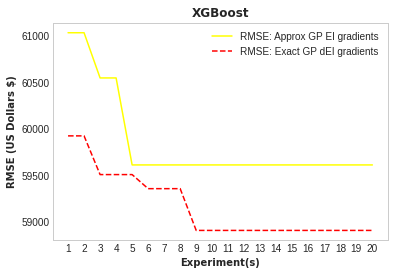

In [70]:
### Visualise!

title = obj_func
plt.figure()

plt.plot(min_rmse_approx, color = 'Yellow', label='RMSE: Approx GP EI gradients')
plt.plot(min_rmse_exact, color = 'Red', label='RMSE: Exact GP dEI gradients', ls='--')# r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('Experiment(s)', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('RMSE (US Dollars $)', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(min_rmse_approx)
plt.xticks(np.arange(count), np.arange(1, count + 1))
plt.grid(b=None)
plt.show() #visualize!


In [71]:
time_approx, time_exact


(1992.3479568958282, 2047.1825053691864)

In [72]:
min(min_rmse_exact), min(min_rmse_approx)


(58909.59940760899, 59612.82267483437)